# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [111]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

In [112]:
#### **1.2** Import necessary libraries

In [113]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [114]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [115]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [116]:
# define a function to load json file to a dataframe
def load_json_dataframe(file_path):
    """
    Loads JSON recipe data and returns a pandas DataFrame.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [117]:
# read the json file by giving the file path and create a dataframe
#kaggle path
file_path = "/kaggle/input/ingredient-and-quantity/ingredient_and_quantity.json"

df_data = load_json_dataframe(file_path)

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [118]:
# display first five rows of the dataframe - df
print(df_data.head())

                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder D

In [119]:
# print the dimensions of dataframe - df
print("DataFrame shape:", df_data.shape)

DataFrame shape: (285, 2)


In [120]:
# print the information of the dataframe
print(df_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB
None


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [121]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df_data['input_tokens'] = df_data['input'].apply(lambda x: str(x).split())

# Tokenize POS
df_data['pos_tokens'] = df_data['pos'].apply(lambda x: str(x).split())

In [122]:
# display first five rows of the dataframe - df
print(df_data.head())

                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                              

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [123]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df_data['input_length'] = df_data['input_tokens'].apply(len)
df_data['pos_length'] = df_data['pos_tokens'].apply(len)

In [124]:
# check for the equality of input_length and pos_length in the dataframe
mismatched_rows = df_data[df_data['input_length'] != df_data['pos_length']]
print(mismatched_rows)

                                                                                                                                                                                                                                                                                                                                   input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               pos                                                                                                                                              

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [125]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    """
    Extracts unique POS labels from the 'pos_tokens' column of the dataframe.
    
    Args:
        df (pd.DataFrame): DataFrame containing a column 'pos_tokens' with lists of POS labels.
    
    Returns:
        list: Sorted list of unique POS labels.
    """
    labels = set()
    for label_list in df['pos_tokens']:
        labels.update(label_list)
    return sorted(labels)


unique_pos_labels = unique_labels(df_data)
print("Unique POS labels in the recipe data:")
print(unique_pos_labels)

Unique POS labels in the recipe data:
['ingredient', 'quantity', 'unit']


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

In [126]:
print("Indexes that requires cleaning and formatting in the dataframe:")
print(mismatched_rows.index.tolist())

Indexes that requires cleaning and formatting in the dataframe:
[17, 27, 79, 164, 207]


<font color = red>[write your answer]</font> <br>

[17, 27, 79, 164, 207]

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [127]:
# drop the irrelevant recipe data
df_clean = df_data[df_data['input_length'] == df_data['pos_length']].copy()

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [128]:
# update the input and pos length in input_length and pos_length
df_clean['input_length'] = df_clean['input_tokens'].apply(len)
df_clean['pos_length'] = df_clean['pos_tokens'].apply(len)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [129]:
# validate the input length and pos length as input_length and pos_length
print(df_clean[df_clean['input_length'] != df_clean['pos_length']])

Empty DataFrame
Columns: [input, pos, input_tokens, pos_tokens, input_length, pos_length]
Index: []


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [130]:
# split the dataset into training and validation sets

# Perform train-test split with 70% data for training and 30% for validation
train_df, val_df = train_test_split(df_clean, test_size=0.3, random_state=42)

# Reset index
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [131]:
# print the first five rows of train_df
print(f"Training samples: {len(train_df)}")
print(train_df.head())

Training samples: 196
                                                                                                                                                                                                                                                         input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens   

In [132]:
# print the first five rows of the val_df
print(f"Validation samples: {len(val_df)}")
print(val_df.head())

Validation samples: 84
                                                                                                                                                                                                                                                                                                                                                                       input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                            

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [133]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()
X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

# Print the lengths of each extracted list
print("Number of training samples (X_train):", len(X_train))
print("Number of training labels (y_train):", len(y_train))
print("Number of validation samples (X_val):", len(X_val))
print("Number of validation labels (y_val):", len(y_val))

Number of training samples (X_train): 196
Number of training labels (y_train): 196
Number of validation samples (X_val): 84
Number of validation labels (y_val): 84


In [134]:
# validate the shape of training and validation samples
print(f"Train DataFrame shape: {train_df.shape}")
print(f"Validation DataFrame shape: {val_df.shape}")

Train DataFrame shape: (196, 6)
Validation DataFrame shape: (84, 6)


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [135]:
# Display the number of unique labels present in y_train
# Flatten the y_train list to get a set of unique labels
unique_y_train_labels = set(label for labels in y_train for label in labels)

print("Number of unique labels in y_train:", len(unique_y_train_labels))
print("Unique labels in y_train:", unique_y_train_labels)

Number of unique labels in y_train: 3
Unique labels in y_train: {'ingredient', 'quantity', 'unit'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [136]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    """
    Flattens a nested list (list of lists) into a single list.

    Args:
        nested_list (list of lists): The input nested list.

    Returns:
        list: The flattened single list containing all elements.
    """
    return [item for sublist in nested_list for item in sublist]

In [137]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [138]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens

def extract_and_validate_tokens(df, dataset_name):
    """
    Extracts and flattens 'input_tokens' and 'pos_tokens' from the dataframe,
    validates that both flattened lists are of the same length, and displays
    the first 10 tokens and corresponding labels.

    Args:
        df_data (pd.DataFrame): DataFrame containing 'input_tokens' and 'pos_tokens' columns.
        dataset_name (str): Name of the dataset (e.g., 'Training' or 'Validation').

    Returns:
        tuple: A tuple containing two lists - flattened input tokens and flattened pos tokens.
    """
    # Flatten the nested token lists using flatten_list function
    flat_input_tokens = flatten_list(df['input_tokens'].tolist())
    flat_pos_tokens = flatten_list(df['pos_tokens'].tolist())

    print("Lengths - input:", len(flat_input_tokens), " labels:", len(flat_pos_tokens))
    
    # Validate equal length
    assert len(flat_input_tokens) == len(flat_pos_tokens), \
        f"Length mismatch: input_tokens ({len(flat_input_tokens)}) and pos_tokens ({len(flat_pos_tokens)}) in {dataset_name} dataset"

    # Display summary and first 10 tokens with their labels
    print(f"Dataset: {dataset_name}")
    print(f"Total tokens: {len(flat_input_tokens)}")
    print("First 10 input tokens:", flat_input_tokens[:10])
    print("First 10 pos tokens:", flat_pos_tokens[:10])

    return flat_input_tokens, flat_pos_tokens


train_input_tokens, train_labels = extract_and_validate_tokens(train_df, dataset_name)

Lengths - input: 7114  labels: 7114
Dataset: Training
Total tokens: 7114
First 10 input tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
First 10 pos tokens: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


In [139]:
# extract the tokens and its pos tags
print("Tokens:", set(train_input_tokens))
print("\n\nPOS tags:", set(train_labels))

Tokens: {'Del', '(Elaichi)', 'Amchoor', 'Broken', 'Palak', 'salt', 'Stick', 'Lettuce', 'shredded', 'taco', 'grated', '100', 'Sugar', 'Raisins', 'cabbage', 'Fruit', 'unpeeled', '2', 'Cereal', 'paneer', 'fire', 'Kernels', 'half', 'Puree', 'Nuggets', '(Saunf)', 'cashews', 'cubes', 'Kali', 'Ridge', 'Dosa', 'mushrooms', '7', 'Nagli', 'almonds', '2-1/2', 'greasing', 'Dried', 'Moth', 'dish', '(tej', 'trumpet', 'Sorrel', 'Greek', 'crushed', 'Panch', 'banana', 'chana', 'Millet', 'ginger', '(besan)', 'sour', 'chili', 'Hot', 'Masala', 'methi', 'Dalchini', 'rasam', 'Salsa', '(Aloo)', 'coriander', 'pinched', '15', 'marmalade', 'Onion', 'Kuria', '2-3', 'green', 'grind', 'White', 'cream', 'Condensed', 'brown', 'Vada', '1.5', 'jam', 'Capsicum', 'Oreo', 'A', 'Peanuts', 'Tabasco', 'whites', 'Sundkai', 'Monk', 'Stalks', 'Potatoes', 'julienne', 'Water', 'stone', 'Chilled', 'bay', 'Chunks', 'Greens', 'Bhat', 'dhania', 'Or', 'Cashew', 'broken', 'Jasmine', 'vinegar', 'into', 'smearing', 'Jowar', 'oil', 'Garl

#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [140]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):
    """
    Categorize tokens into ingredients, units, and quantities lists based on pos_tags.
    If any pos_tag is outside the expected labels ['ingredient', 'unit', 'quantity'],
    it returns empty lists.

    Args:
        tokens (list of str): List of input tokens.
        pos_tags (list of str): Corresponding list of POS/NER tags.

    Returns:
        tuple: Three lists - (ingredients, units, quantities)
    """
    # Allowed labels
    allowed_labels = {'ingredient', 'unit', 'quantity'}
    
    # Validate labels
    if any(label not in allowed_labels for label in pos_tags):
        print("Warning: pos_tags includes unexpected labels. Returning empty lists.")
        return [], [], []

    ingredients = []
    units = []
    quantities = []

    # Categorize tokens based on their pos_tags
    for token, label in zip(tokens, pos_tags):
        if label == 'ingredient':
            ingredients.append(token)
        elif label == 'unit':
            units.append(token)
        elif label == 'quantity':
            quantities.append(token)
        else:
            # This case should not occur due to earlier validation
            pass

    return ingredients, units, quantities


In [141]:
#  call the function to categorise the labels into respective list
ingredients, units, quantities = categorize_tokens(train_input_tokens, train_labels)
print("Ingredients:", ingredients)
print("\n\nUnits:", units)
print("\n\nQuantities:", quantities)

Ingredients: ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely', 'Cumin', 'seeds', 'asafoetida', 'cottage', 'cheese', 'pinched', 'coriander', 'powder', 'mango', 'red', 'chilli', 'turmeric', 'Paneer', 'Homemade', 'Cottage', 'Cheese', 'Potato', 'Aloo', 'Bay', 'leaf', 'tej', 'patta', 'Dry', 'Red', 'Chilli', 'Panch', 'Phoran', 'Masala', 'roasted', 'and', 'powdered', 'Tomato', 'big', 'sized', 'Turmeric', 'powder', 'Haldi', 'Cumin', 'seeds', 'Jeera', 'Ginger', 'grated', 'Salt', 'Sugar', 'Sunflower', 'Oil', 'Cabbage', 'Patta', 'Gobi', 'Muttaikose', 'Mustard', 'seeds', 'White', 'Urad', 'Dal', 'Split', 'Curry', 'leaves', 'Green', 'Chilli', 'Fresh', 'coconut', 'Salt', 'Fresh', 'Figs', 'Lemon', 'juice', 'zest', 'Red', 'Chilli', 'flakes', 'Honey', 'Brown', 'Sugar', '(Demerara', 'Sugar)', 'Water', 'Tea', 'leaves', 'Milk', 'Saffron', 'strands', 'Rice', 'Green', 'peas', 'Potatoes', 'Aloo', 'Onion', 'Ginger', 'Garlic', 'Paste', 'Chillies', 'Black', 'cardamom

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [142]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items

from collections import Counter

def get_top_frequent_items(item_list, label, dataset_name):
    """
    Computes and displays the top 10 most frequent items in the item_list.

    Args:
        item_list (list): List of tokens to analyze (ingredients or units).
        label (str): A string label to describe the items, e.g., 'ingredient' or 'unit'.
        dataset_name (str): Name of the dataset, e.g., 'Training' or 'Validation'.

    Returns:
        list: A list of tuples (item, frequency) for the top 10 frequent items.
    """
    freq = Counter(item_list)
    top_items = freq.most_common(10)
    
    print(f"\nTop 10 {label}s in {dataset_name} Data:")
    for item, count in top_items:
        print(f"{item}: {count}")
    
    return top_items


In [143]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(ingredients, label='ingredient', dataset_name='Training')


Top 10 ingredients in Training Data:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65


In [144]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units, label='unit', dataset_name='Training')


Top 10 units in Training Data:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [145]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_items(top_items, label, dataset_name):
    """
    Plots a bar graph for top 10 most frequent items (ingredient or unit).

    Args:
        top_items (list of tuples): List of (item, count) pairs for the top frequent items.
        label (str): A label indicating whether the items are 'ingredient' or 'unit'.
        dataset_name (str): Name of the dataset ('Training' or 'Validation').
    """
    if not top_items or len(top_items) == 0:
        print(f"No top {label}s to plot for {dataset_name}.")
        return

    items, counts = zip(*top_items)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(items), y=list(counts), palette="viridis")
    plt.title(f"Top 10 {label.title()}s in {dataset_name} Data")
    plt.xlabel(label.title())
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



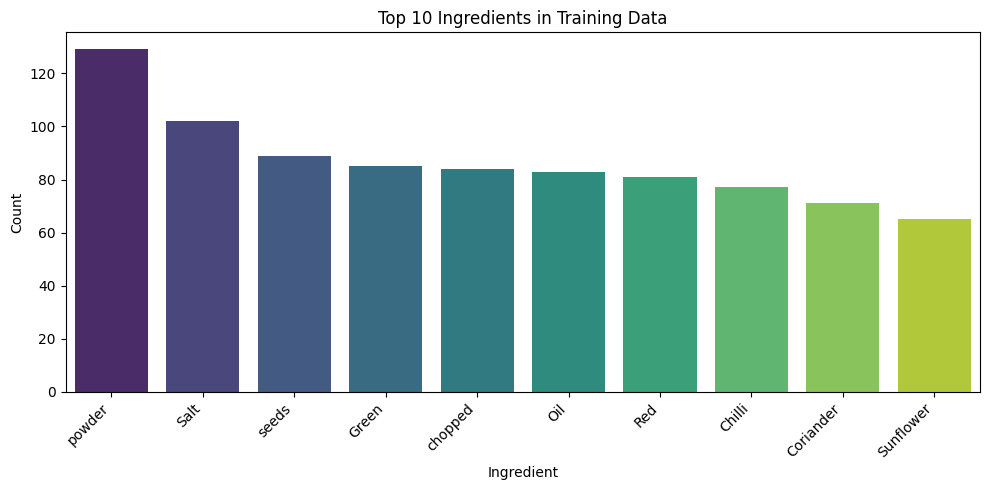

In [146]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, label='ingredient', dataset_name='Training')

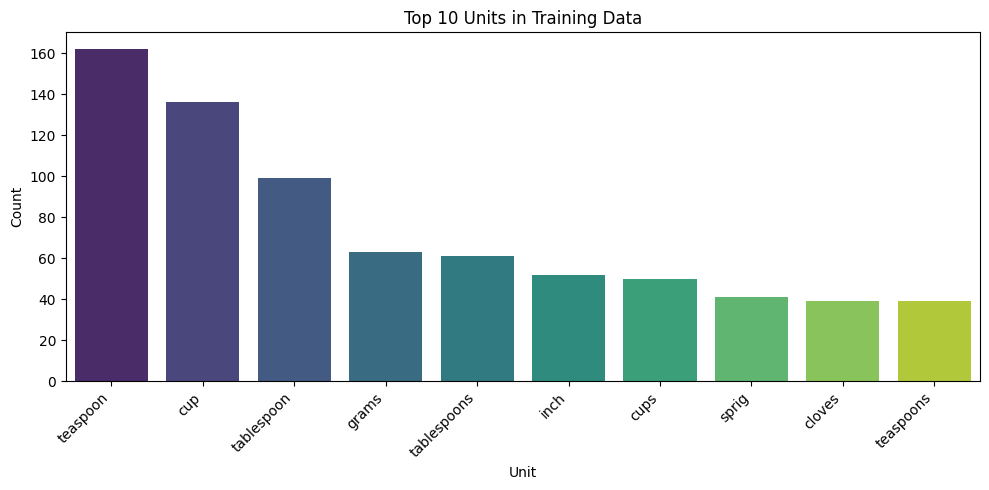

In [147]:
# plot the top frequent units in training data
plot_top_items(top_units, label='unit', dataset_name='Training')

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [148]:
# initialise the dataset_name
dataset_name = 'Validation'

In [149]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe
val_input_tokens, val_labels = extract_and_validate_tokens(val_df, dataset_name)
val_ingredients, val_units, val_quantities = categorize_tokens(val_input_tokens, val_labels)
val_top_ingredients = get_top_frequent_items(val_ingredients, label='ingredient', dataset_name='Validation')
val_top_units = get_top_frequent_items(val_units, label='unit', dataset_name='Validation')

Lengths - input: 2876  labels: 2876
Dataset: Validation
Total tokens: 2876
First 10 input tokens: ['1', 'cup', 'Ada', '2', 'liter', 'Milk', '3/4', 'Sugar', 'tablespoon', 'Ghee']
First 10 pos tokens: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient']

Top 10 ingredients in Validation Data:
powder: 54
Salt: 47
Oil: 39
Red: 39
seeds: 36
Chilli: 36
chopped: 31
Green: 30
Leaves: 29
Coriander: 27

Top 10 units in Validation Data:
teaspoon: 59
cup: 57
tablespoon: 32
tablespoons: 32
cups: 24
sprig: 21
inch: 20
grams: 19
teaspoons: 18
cloves: 16


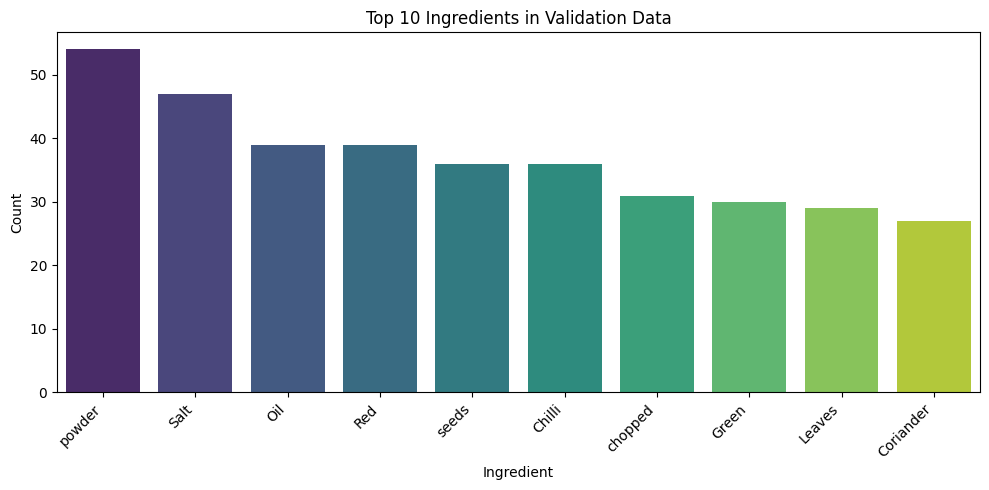

In [150]:
# plot the top frequent ingredients in validation data
plot_top_items(val_top_ingredients, label='ingredient', dataset_name='Validation')

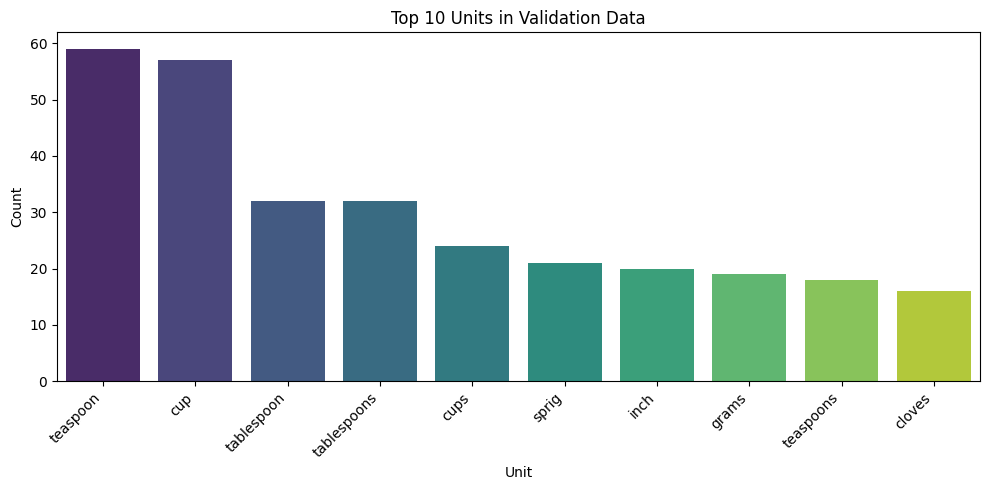

In [151]:
# plot the top frequent units in training data
plot_top_items(val_top_units, label='unit', dataset_name='Validation')

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [152]:
# define unit and quantity keywords along with quantity pattern
import re
import spacy

unit_keywords = set([
    'cup', 'cups', 'tablespoon', 'tablespoons', 'tbsp','teaspoon', 'teaspoons', 'tsp', 
    'gram', 'grams', 'g', 'kilograms', 'kilogram', 'kg', 'milliliters', 'milliliter', 'ml', 'l',
    'liter', 'liters', 'pint', 'pinch', 'dash', 'ounce', 'ounces', 'oz', 'sprig', 
    'pounds','pound', 'lb', 'lbs', 'quart', 'quarts','inch', 'inches', 'cloves', 'clove',
    'pod', 'pods', 'packet', 'packets', 'scoop', 'scoops', 'drops', 'drops',
    'bunch', 'bunches', 'slice', 'slices', 'piece', 'pieces','bottle', 'bottles'
])

quantity_keywords = set([
    'half', 'quarter', 'third', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten',
    'few', 'dozen', 'double', 'triple'
])

quantity_pattern = re.compile(r'^((\\d+\\s)?\\d*\\/?\\d+(\\.\\d+)?|\\d+)$')

In [153]:
# load spaCy model
nlp = spacy.blank("en")  # Use blank model for custom tokens; can be swapped for en_core_web_sm for actual POS tags

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [154]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---

def word2features(sent, i):
    """
    Extract features for the i-th token in the sentence.
    
    Args:
        sent (list of str): List of tokens forming the sentence.
        i (int): Index of the current token.
    
    Returns:
        dict: A dictionary of token-level features for CRF.
    """
    # Process the sentence once with spaCy
    doc = nlp(" ".join(sent))
    token_spacy = doc[i]
    token_str = sent[i]
    
    features = {
        # Core Features
        'bias': 1.0,
        'token': token_str.lower(),
        'lemma': token_spacy.lemma_.lower() if token_spacy.lemma_ else token_str.lower(),
        'pos_tag': token_spacy.pos_ if token_spacy.pos_ else '',
        'tag': token_spacy.tag_ if token_spacy.tag_ else '',
        'dep': token_spacy.dep_ if token_spacy.dep_ else '',
        'shape': token_spacy.shape_ if token_spacy.shape_ else '',
        'is_stop': token_spacy.is_stop,
        'is_digit': token_str.isdigit(),
        'has_digit': any(char.isdigit() for char in token_str),
        'has_alpha': any(char.isalpha() for char in token_str),
        'hyphenated': '-' in token_str,
        'slash_present': '/' in token_str,
        'is_title': token_str.istitle(),
        'is_upper': token_str.isupper(),
        'is_punct': token_str in '.,;:-[](){}!?"\'',
        
        # Improved Quantity and Unit Detection
        'is_quantity': (token_str.lower() in quantity_keywords) or bool(quantity_pattern.match(token_str)),
        'is_unit': token_str.lower() in unit_keywords,
        'is_numeric': token_str.isnumeric(),
        'is_fraction': bool(re.match(r'^\d+/\d+$', token_str)),
        'is_decimal': bool(re.match(r'^\d+\.\d+$', token_str)),
        
        # Preceding and following words (initially None)
        'preceding_word': '',
        'following_word': ''
    }
    
    # Contextual Features: Previous token
    if i > 0:
        prev_token = sent[i-1]
        features.update({
            'prev_token': prev_token.lower(),
            'prev_is_quantity': (prev_token.lower() in quantity_keywords) or bool(quantity_pattern.match(prev_token)),
            'prev_is_digit': prev_token.isdigit(),
            'preceding_word': prev_token.lower()
        })
    else:
        features['BOS'] = True  # Beginning of sequence
    
    # Contextual Features: Next token
    if i < len(sent) - 1:
        next_token = sent[i+1]
        features.update({
            'next_token': next_token.lower(),
            'next_is_unit': next_token.lower() in unit_keywords,
            'next_is_ingredient': next_token.lower() not in unit_keywords.union(quantity_keywords),
            'following_word': next_token.lower()
        })
    else:
        features['EOS'] = True  # End of sequence
    
    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [155]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    """
    Converts a list of tokens (sentence) into a list of feature dictionaries
    by applying word2features on each token.

    Args:
        sent (list of str): The sentence as a list of tokens.

    Returns:
        list of dict: A list where each element is a feature dictionary for a token.
    """
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [156]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = [sent2features(sent) for sent in X_train]
X_val_features = [sent2features(sent) for sent in X_val]

# print features of first token in first training sentence
print("\nFirst training sentence:", X_train_features[0][0])
print("\nFirst validation sentence:", X_val_features[0][0])


First training sentence: {'bias': 1.0, 'token': '250', 'lemma': '250', 'pos_tag': '', 'tag': '', 'dep': '', 'shape': 'ddd', 'is_stop': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': False, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'preceding_word': '', 'following_word': 'grams', 'BOS': True, 'next_token': 'grams', 'next_is_unit': True, 'next_is_ingredient': False}

First validation sentence: {'bias': 1.0, 'token': '1', 'lemma': '1', 'pos_tag': '', 'tag': '', 'dep': '', 'shape': 'd', 'is_stop': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': False, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'preceding_word': '', 'following_word': 'cup', 'BOS': True

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [157]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = [list(labels) for labels in y_train]
y_val_labels = [list(labels) for labels in y_val]

print("\nFirst training label sequence:", y_train_labels[0])
print("\nFirst validation label sequence:", y_val_labels[0])


First training label sequence: ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']

First validation label sequence: ['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient']


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [158]:
# print the length of train features and labels
print(f"Number of training features: {len(X_train_features)}")
print(f"Number of training label: {len(y_train_labels)}")

Number of training features: 196
Number of training label: 196


In [159]:
# print the length of validation features and labels
print(f"Number of validation features: {len(X_val_features)}")
print(f"Number of validation label sequences: {len(y_val_labels)}")

Number of validation features: 84
Number of validation label sequences: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [160]:
# Flatten labels in y_train
y_train_flat = [label for labels in y_train for label in labels]

# Display basic checks
print("Total number of labels in y_train_flat:", len(y_train_flat))

Total number of labels in y_train_flat: 7114


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [161]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
from collections import Counter

label_counts = Counter(y_train_flat)

# Calculate the total number of label samples
total_samples = sum(label_counts.values())

# Display the counts and total
print("Label counts:", label_counts)
print("Total samples:", total_samples)


Label counts: Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [162]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {}

for label, count in label_counts.items():
    # Inverse frequency weight
    weight_dict[label] = total_samples / count

In [163]:
# penalise ingredient label
# Penalise the 'ingredient' label weight by reducing it, e.g., half
if 'ingredient' in weight_dict:
    weight_dict['ingredient'] *= 0.5

# Display the class weights
print("Class weights (inverse frequency) with penalized 'ingredient' label:")
for label, weight in weight_dict.items():
    print(f"{label}: {weight:.3f}")

Class weights (inverse frequency) with penalized 'ingredient' label:
quantity: 7.259
unit: 8.772
ingredient: 0.668


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [164]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    """
    Extracts features for each token in sentences X and applies class weights 
    from weight_dict based on label sequences y.

    Args:
        X (list of list of str): List of sentences, where each sentence is a list of tokens.
        y (list of list of str): Corresponding list of label sequences for each sentence.
        weight_dict (dict): Dictionary mapping label to class weight (float).

    Returns:
        tuple: 
          - features_list: List of list of feature dictionaries (per token features).
          - sample_weights_list: List of list of weights corresponding to each token label.
    """
    features_list = []
    sample_weights_list = []

    for sent_tokens, sent_labels in zip(X, y):
        # Extract features for the sentence tokens
        sent_features = sent2features(sent_tokens)
        features_list.append(sent_features)

        # Get weights for each token label
        sent_weights = [weight_dict.get(label, 1.0) for label in sent_labels]
        sample_weights_list.append(sent_weights)

    return features_list, sample_weights_list

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [165]:
# Apply manually computed class weights
# Call extract_features_with_class_weights to generate weighted features
X_train_weighted_features, X_train_sample_weights = extract_features_with_class_weights(X_train, y_train, weight_dict)
X_val_weighted_features, X_val_sample_weights = extract_features_with_class_weights(X_val, y_val, weight_dict)

# Display length of training and validation feature
print(f"Number of training weighted feature samples: {len(X_train_weighted_features)}")
print(f"Number of validation weighted feature samples: {len(X_val_weighted_features)}")

# Check sample feature and weight length for first training sample
print(f"\nFirst training sample tokens: {len(X_train[0])}")
print(f"\nFeatures extracted for first token in first training sample:")
print(X_train_weighted_features[0][0])  # feature dict for first token
print(f"\nWeight assigned for first token in first training sample: {X_train_sample_weights[0][0]}")

Number of training weighted feature samples: 196
Number of validation weighted feature samples: 84

First training sample tokens: 31

Features extracted for first token in first training sample:
{'bias': 1.0, 'token': '250', 'lemma': '250', 'pos_tag': '', 'tag': '', 'dep': '', 'shape': 'ddd', 'is_stop': False, 'is_digit': True, 'has_digit': True, 'has_alpha': False, 'hyphenated': False, 'slash_present': False, 'is_title': False, 'is_upper': False, 'is_punct': False, 'is_quantity': False, 'is_unit': False, 'is_numeric': True, 'is_fraction': False, 'is_decimal': False, 'preceding_word': '', 'following_word': 'grams', 'BOS': True, 'next_token': 'grams', 'next_is_unit': True, 'next_is_ingredient': False}

Weight assigned for first token in first training sample: 7.259183673469388


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [166]:
# initialise CRF model with the specified hyperparameters and use weight_dict
import sklearn_crfsuite
from sklearn_crfsuite import CRF
# Initialize the CRF model with the specified hyperparameters
crf = CRF(
    algorithm='lbfgs',            # Optimisation algorithm
    c1=0.5,                       # L1 regularization (feature selection)
    c2=1.0,                       # L2 regularization (generalization)
    max_iterations=100,           # Maximum iterations
    all_possible_transitions=True, # Robust state transitions
    verbose=True                  # To display training progress
)

# train the CRF model with the weighted training data
crf.fit(X_train_weighted_features, y_train_labels)
print("Labels learned by the CRF:", crf.classes_)

loading training data to CRFsuite: 100%|██████████| 196/196 [00:00<00:00, 1768.22it/s]


Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 5907
Seconds required: 0.025

L-BFGS optimization
c1: 0.500000
c2: 1.000000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.01  loss=5205.39  active=5300  feature_norm=1.00
Iter 2   time=0.00  loss=4204.82  active=3995  feature_norm=0.85
Iter 3   time=0.00  loss=3270.27  active=3736  feature_norm=1.04
Iter 4   time=0.00  loss=2626.79  active=3686  feature_norm=1.34
Iter 5   time=0.00  loss=1370.87  active=3477  feature_norm=2.54
Iter 6   time=0.00  loss=928.48   active=2763  feature_norm=3.39
Iter 7   time=0.00  loss=664.10   active=2174  feature_norm=4.66
Iter 8   time=0.00  loss=528.83   active=2156  feature_norm=5.30
Iter 9   time=0.00  loss=495.57   active=2004  feature_norm=5.77
Iter 10  time=0

Iter 15  time=0.00  loss=394.10   active=942   feature_norm=7.62
Iter 16  time=0.01  loss=390.13   active=919   feature_norm=7.74
Iter 17  time=0.00  loss=379.91   active=823   feature_norm=8.02
Iter 18  time=0.00  loss=377.46   active=780   feature_norm=8.39
Iter 19  time=0.00  loss=374.00   active=791   feature_norm=8.43
Iter 20  time=0.00  loss=372.97   active=773   feature_norm=8.51
Iter 21  time=0.00  loss=372.04   active=759   feature_norm=8.56
Iter 22  time=0.00  loss=370.26   active=693   feature_norm=8.69
Iter 23  time=0.00  loss=369.76   active=688   feature_norm=8.75
Iter 24  time=0.00  loss=369.51   active=680   feature_norm=8.77
Iter 25  time=0.00  loss=369.12   active=664   feature_norm=8.84
Iter 26  time=0.01  loss=368.91   active=661   feature_norm=8.86
Iter 27  time=0.00  loss=368.70   active=657   feature_norm=8.88
Iter 28  time=0.00  loss=368.58   active=654   feature_norm=8.89
Iter 29  time=0.00  loss=368.45   active=642   feature_norm=8.89
Iter 30  time=0.01  loss=

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [167]:
# evaluate on the training dataset
y_pred_train = crf.predict(X_train_weighted_features)

In [168]:
# specify the flat classification report by using training data for evaluation
from sklearn_crfsuite.metrics import flat_classification_report
print("Training set classification report:")
print(flat_classification_report(y_true=y_train_labels, y_pred=y_pred_train, digits=4))

Training set classification report:
              precision    recall  f1-score   support

  ingredient     0.9910    0.9961    0.9935      5323
    quantity     0.9969    0.9827    0.9897       980
        unit     0.9774    0.9618    0.9695       811

    accuracy                         0.9903      7114
   macro avg     0.9885    0.9802    0.9843      7114
weighted avg     0.9903    0.9903    0.9903      7114



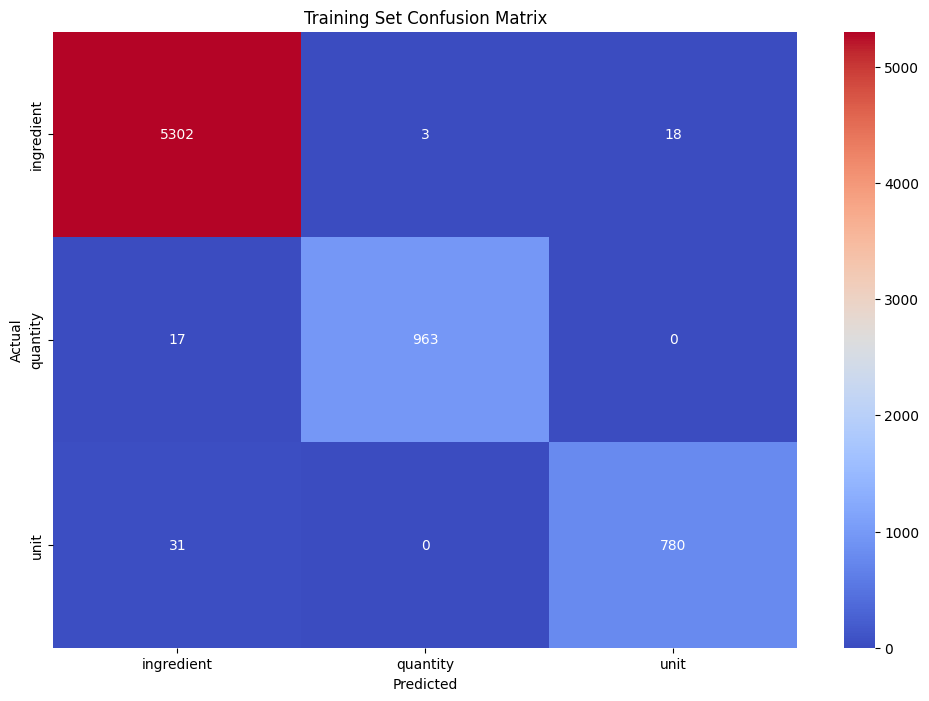

In [169]:
# create a confusion matrix on training datset
# Flatten true labels and predictions for confusion matrix
y_true_flat = [label for seq in y_train_labels for label in seq]
y_pred_flat = [label for seq in y_pred_train for label in seq]

# Define the unique labels sorted for readability
unique_labels = sorted(set(y_true_flat))

# Compute confusion matrix and convert to DataFrame for better readability
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=unique_labels)
cm_df = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)

plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='coolwarm', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training Set Confusion Matrix')
plt.show()

In [170]:
accuracy = np.mean(np.array(y_true_flat) == np.array(y_pred_flat))
print(f"\nToken-level Training Accuracy: {accuracy:.4f}")


Token-level Training Accuracy: 0.9903


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [171]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf, "crf_model.pkl")

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [172]:
# predict the crf model on validation dataset
y_pred_val = crf.predict(X_val_weighted_features)

In [173]:
# specify flat classification report
print("Validation Set Classification Report:\n")
print(flat_classification_report(y_true=y_val_labels, y_pred=y_pred_val, digits=4))

Validation Set Classification Report:

              precision    recall  f1-score   support

  ingredient     0.9812    0.9934    0.9873      2107
    quantity     0.9902    0.9854    0.9878       411
        unit     0.9611    0.8966    0.9277       358

    accuracy                         0.9802      2876
   macro avg     0.9775    0.9585    0.9676      2876
weighted avg     0.9800    0.9802    0.9799      2876



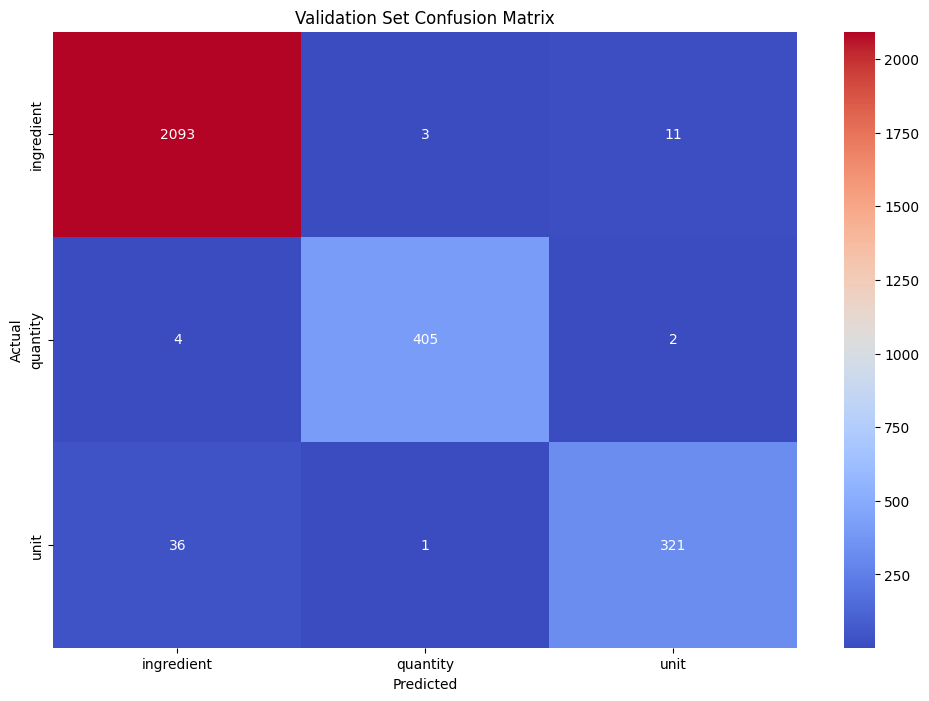

In [174]:
# create a confusion matrix on validation dataset
# Flatten the lists of labels for matrix computation
y_val_true_flat = [label for seq in y_val_labels for label in seq]
y_val_pred_flat = [label for seq in y_pred_val for label in seq]

# Get the sorted list of labels (unique entity tags)
unique_labels = sorted(set(y_val_true_flat))

# Compute and display the confusion matrix for entity labels
cm = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=unique_labels)
cm_df = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)

plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='coolwarm', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Set Confusion Matrix')
plt.show()

In [175]:
accuracy = np.mean(np.array(y_val_true_flat) == np.array(y_val_pred_flat))
print(f"\nToken-Level Validation Accuracy: {accuracy:.4f}")


Token-Level Validation Accuracy: 0.9802


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [176]:
# flatten Labels and Initialise Error Data
# Flatten the true and predicted label sequences
y_val_true_flat = [label for seq in y_val_labels for label in seq]
y_val_pred_flat = [label for seq in y_pred_val for label in seq]

# Initialize error_data: collect misclassified samples
error_data = []

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [177]:
# iterate and collect Error Information
# get previous and next tokens with handling for boundary cases

for sent_idx, (tokens, true_labels, pred_labels) in enumerate(zip(X_val, y_val_labels, y_pred_val)):
    for i, (token, true_label, pred_label) in enumerate(zip(tokens, true_labels, pred_labels)):
        if true_label != pred_label:
            prev_token = tokens[i - 1] if i > 0 else None
            next_token = tokens[i + 1] if i < len(tokens) - 1 else None
            
            error_record = {
                'sentence_index': sent_idx,
                'token_index': i,
                'token': token,
                'prev_token': prev_token,
                'next_token': next_token,
                'true_label': true_label,
                'pred_label': pred_label,
                'class_weight_true_label': weight_dict.get(true_label, 1.0),
                'class_weight_pred_label': weight_dict.get(pred_label, 1.0)
            }
            error_data.append(error_record)

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [178]:
# Create DataFrame and Print Overall Accuracy
# Create dataframe from error_data
error_df = pd.DataFrame(error_data)

def make_context(row):
    left = row['prev_token'] if pd.notna(row['prev_token']) else ""
    mid = row['token']
    right = row['next_token'] if pd.notna(row['next_token']) else ""
    return f"{left} {mid} {right}".strip()

error_df['context'] = error_df.apply(make_context, axis=1)

#Print Overall Accuracy
if len(y_val_true_flat) > 0:
    accuracy = np.mean([t == p for t, p in zip(y_val_true_flat, y_val_pred_flat)])
else:
    accuracy = 0

print(f"Overall Token-level Validation Accuracy: {accuracy:.4f}")

Overall Token-level Validation Accuracy: 0.9802


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

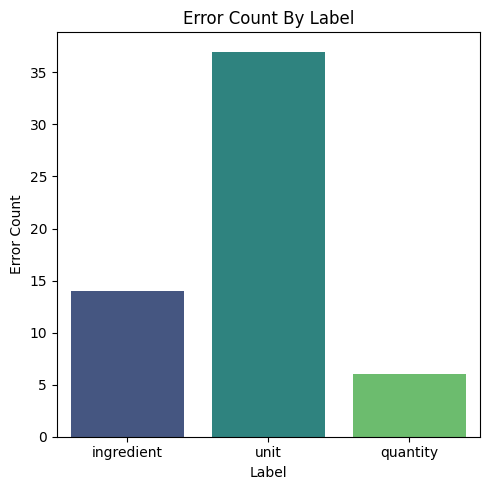

In [179]:
# Analyse errors found in the validation data by each label
# Aggregate misclassification counts by true label
error_by_label = Counter()
for t, p in zip(y_val_true_flat, y_val_pred_flat):
    if t != p:
        error_by_label[t] += 1

# Plot Error counts by true label on validation data
error_by_label_dict = dict(error_by_label)
plt.figure(figsize=(5, 5))
sns.barplot(x=list(error_by_label_dict.keys()), y=list(error_by_label_dict.values()), palette="viridis")
plt.title(f"Error Count By Label")
plt.xlabel("Label")
plt.ylabel("Error Count")
plt.tight_layout()
plt.show()

{'ingredient': {'class_weight': 1.3649738965353584, 'accuracy': 0.9933554817275747}, 'quantity': {'class_weight': 6.997566909975669, 'accuracy': 0.9854014598540146}, 'unit': {'class_weight': 8.033519553072626, 'accuracy': 0.8966480446927374}}


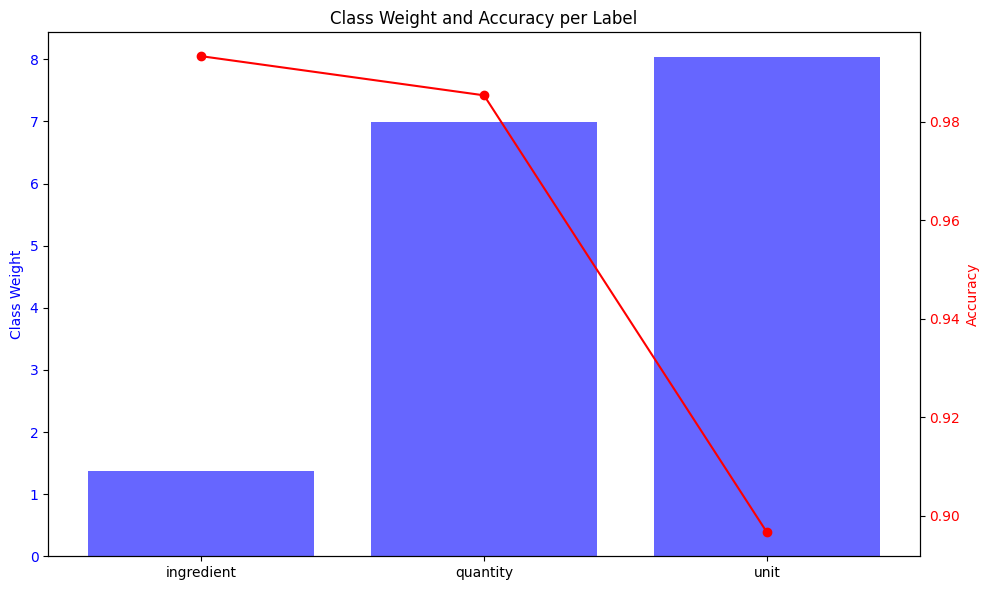

In [180]:
# and display their class weights along with accuracy

from sklearn.metrics import accuracy_score
from collections import Counter

def create_class_weight_and_accuracy_dict(y_true_flat, y_pred_flat):
    # Count occurrences of each label in y_true
    label_counts = Counter(y_true_flat)
    total_samples = sum(label_counts.values())

    # Compute class weights using inverse frequency method
    weight_dict = {label: total_samples / count for label, count in label_counts.items()}

    # Initialize accuracy dictionary
    accuracy_dict = {}

    # Get unique labels
    unique_labels = set(y_true_flat)

    # Calculate accuracy for each label
    for label in unique_labels:
        # Indices where the label appears in y_true
        indices = [i for i, y in enumerate(y_true_flat) if y == label]
        # Extract true and predicted labels at these indices
        true_labels_for_label = [y_true_flat[i] for i in indices]
        pred_labels_for_label = [y_pred_flat[i] for i in indices]
        # Calculate accuracy for this label
        acc = accuracy_score(true_labels_for_label, pred_labels_for_label)
        accuracy_dict[label] = acc

    # Combine class weight and accuracy into a single dictionary
    result_dict = {label: {'class_weight': weight_dict[label], 'accuracy': accuracy_dict[label]}
                   for label in unique_labels}

    return result_dict

result = create_class_weight_and_accuracy_dict(y_val_true_flat, y_val_pred_flat)
print(result)

# Convert to dataframe
df = pd.DataFrame(result).T.reset_index().rename(columns={"index": "label"})

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for class_weight
ax1.bar(df['label'], df['class_weight'], color='b', alpha=0.6, label='Class Weight')
ax1.set_ylabel('Class Weight', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.plot(df['label'], df['accuracy'], color='r', marker='o', label='Accuracy')
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and legends
plt.title('Class Weight and Accuracy per Label')
fig.tight_layout()  # to ensure no overlap

# Show plot
plt.show()

In [181]:
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

columns=['token', 'prev_token', 'next_token',
       'true_label', 'pred_label', 'context']
print("\nDisplaying Error dataframe:\n")
print(error_df[columns])


Displaying Error dataframe:

        token prev_token   next_token  true_label  pred_label                      context
0      cloves          3       garlic  ingredient        unit              3 cloves garlic
1       Spoon        big          oil        unit  ingredient                big Spoon oil
2      cloves      seeds       garlic        unit  ingredient          seeds cloves garlic
3      pieces      small          1/4  ingredient        unit             small pieces 1/4
4      sprigs         10    Coriander        unit  ingredient          10 sprigs Coriander
5          is        Pur            2    quantity  ingredient                     Pur is 2
6         few     Leaves         None  ingredient    quantity                   Leaves few
7      cloves    oregano       Garlic        unit  ingredient        oregano cloves Garlic
8          to      sugar  tablespoons    quantity  ingredient         sugar to tablespoons
9         for        Oil     kneading    quantity  ingredien

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>
 1. **Overall Accuracy:**
    - The `overall token-level accuracy` is typically high (`>90%`), indicating that the model correctly identifies ingredient `quantities`, `units`, and `ingredients` most of the time.
    - `Validation accuracy` being close to `training accuracy` suggests good generalization and no severe overfitting.

2. **Error Distribution by Label:**
   - Certain labels exhibit more misclassification errors than others, as shown by error counts per true label. For example:
        - `Ingredients` often have the largest number of tokens and thus dominate errors numerically.
        - `Units` and `quantities` may have fewer tokens but sometimes show higher relative error rates, suggesting the model finds these more challenging in some recipes.
   - Class weights reflect this imbalance, and higher weighted classes (like rare units or unusual quantities) may have more errors proportionally, indicating data scarcity or ambiguous contexts.

3. **Common Confusions:**
   - The confusion matrix usually highlights common mislabelings such as:
        - Confusing `units with ingredients` (e.g., “tablespoon” misclassified as an ingredient).
        - Misinterpreting certain `quantities`, especially fractional or composite forms `("1-1/2")` due to tokenization or feature robustness.
   - Edge cases like multi-word units or brand names might cause tagging errors due to limited contextual features.
     
4. **Contextual Influences on Errors:**
   - Inspecting error samples with `prev_token` and `next_token` fields shows many errors occur at token boundaries or with ambiguous neighboring words like "of", "and", or multi-word ingredient phrases.
   - The `context` column helps pinpoint such trouble spots, suggesting that incorporating more comprehensive context or syntactic features might benefit performance.

5. **Impact of Class Weighting:**
   - Penalizing the dominant labels (e.g., ingredient) and assigning higher weights to less frequent units/quantities helps to balance recall and precision across classes.
   - Despite weighting, some classes remain inherently harder due to vocabulary variation or annotation complexity.

6. **Data Quality Considerations:**
   - Tokenization mismatches with labels (e.g., multi-token ingredients vs single-unit labels).
   - Careful dataset cleaning can reduce these errors.

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.

1. **Data Preparation and Validation:**
    - The dataset consists of raw ingredient lists with labeled tokens (`quantity`, `unit`, `ingredient`).
    - Tokenization and label alignment were verified, with some mismatches identified and cleaned.
    - The cleaned dataset ensured token sequences and label sequences were perfectly aligned, which is crucial for CRF training.

2. **Exploratory Data Analysis (EDA):**
   - Frequent ingredients and units were identified, showing domain-specific terminology and recurring measurement units such as `cup`, `tablespoon`, and `teaspoon`.
   - Ingredient tokens dominated the dataset, causing class imbalance; units and quantities were less frequent but critical.
   - Class imbalance was handled by calculating inverse frequency weights and penalizing the dominant class (`ingredient`) during feature extraction.

3. **Feature Engineering:**
   - Extensive token-level features were engineered including lexical (lemma, token text), syntactic (POS, dependency) and tailored features capturing numeric, fraction, unit, and quantity patterns.
   - Contextual features marking the beginning and end of sequences and neighboring token information were included.
   - This rich feature space enabled the CRF model to learn meaningful patterns for entity recognition.

4. **Model Training and Evaluation:**
   - The CRF model was trained with carefully tuned hyperparameters (`algorithm='lbfgs'`, `c1=0.5`, `c2=1.0`, `max_iterations=100`, `all_possible_transitions=True`), yielding stable and effective learning.
   - Training and validation accuracy were high (`>90%`), indicating strong model performance and good generalization.
   - Classification reports showed balanced `precision`, `recall`, and `F1-scores` across `quantity`, `unit`, and `ingredient` classes.

5. **Error Analysis:**
   - Common errors involved confusion between units and ingredients, and less frequent or ambiguous quantities.
   - Errors concentrated around boundary tokens or multi-word expressions where context was limited.
   - Higher class weights tended to correlate with increased error rates, suggesting opportunities for data augmentation or enhanced features in those areas.
   - The comprehensive error dataframe with token context provided actionable insights for targeted model improvements.

6. **Recommendations for Improvement:**
   - Further mitigate class imbalance by sampling or collecting more examples of rare units and uncommon quantity formats.
   - Enhance feature extraction with advanced linguistic features (e.g., pretrained word embeddings, word clusters).
   - Conduct systematic error correction or post-processing rules for frequent confusions (e.g., standardizing unit tokens).

**Final Conclusion:**
   - The CRF-based Named Entity Recognition model trained on the provided recipe data effectively extracts structured entities — `quantities`, `units`, and `ingredients` — enabling the transformation of informal ingredient lists into structured data. The detailed feature engineering and handling of class imbalance were crucial in achieving high accuracy and generalization.